<a href="https://colab.research.google.com/github/schwallergroup/ai4chem_course/blob/main/notebooks/04 - Unsupervised Learning/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised learning: Clustering

In [1]:
! pip install scikit-learn-extra rdkit plotly

!mkdir data/
!wget https://raw.githubusercontent.com/schwallergroup/ai4chem_course/main/notebooks/04%20-%20Unsupervised%20Learning/data/unknown_clusters.csv -O   data/unknown_clusters.csv
!wget https://raw.githubusercontent.com/schwallergroup/ai4chem_course/main/notebooks/04%20-%20Unsupervised%20Learning/utils.py -O utils.py


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 21.1 MB/s eta 0:00:00
--2024-10-25 17:03:24--  https://raw.githubusercontent.com/schwallergroup/ai4chem_course/main/notebooks/04%20-%20Unsupervised%20Learning/data/unknown_clusters.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153555 (150K) [text/plain]
Saving to: ‘data/unknown_clusters.csv’

data/unknown_cluste 100%[===================>] 149.96K  --.-KB/s    in 0.04s   

2024-10-25 17:03:24 (3.68 MB/s) - ‘data/unknown_clusters.csv’ saved [153555/153555]

--2024-10-25 17:03:24--  https://raw.githubusercontent.com/schwallergroup/ai4chem_course/main/notebooks/04%20-%20Unsupervised%20Learning/utils.py
Resolving raw.githubus

In [2]:
from sklearn.datasets import make_blobs
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd

from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from sklearn.metrics import pairwise_distances

from rdkit.Chem import AllChem, Descriptors, MolFromSmiles, rdMolDescriptors
from rdkit import Chem
from rdkit.Chem import Draw

from utils import plot_3d, plot_2d

## Clustering

> Clustering is a powerful unsupervised learning technique that aims to **group similar data points** together based on their features or attributes.

We can use this to **gain insights into the underlying structure** of large and complex datasets, and to **identify patterns** and relationships that may not be immediately apparent.

In this notebook, we will explore four different clustering algorithms:

- KMeans
- KMedoids
- DBSCAN
- Butina clustering

These algorithms are widely used in a variety of fields, including chemistry, and can help researchers better understand data and make informed decisions.

### In this notebook we will:

- [ ] Generate a synthetic dataset (a toy example).
- [ ] Apply each algorithm to a synthetic dataset.
- [ ] Evaluate performance using clustering metrics.
- [ ] Apply all this to a real-world chemistry dataset.

In the last exercise, you will find the ideal number of clusters, using metrics like silhouette and inertia.

By the end of this notebook, you will have a better understanding of **how clustering works** and **how to apply different clustering algorithms to real-world problems**.

---

### Let's start by generating a synthetic clustering dataset.

We will use the *make_blobs* function from scikit-learn.

The *make_blobs* function generates a set of random data points with a Gaussian distribution. The data points are generated in clusters, with each cluster representing a group of points that have similar features.

The function returns arrays `X` and `y`, with `X` containing the coordinates of each data point, and `y` containing the labels of each data point, indicating which cluster it belongs to.

By using different values for the parameters of the *make_blobs* function, we can generate synthetic datasets with different characteristics of the clusters, different numbers of clusters, features, and standard deviations.

We can use these datasets to evaluate different clustering algorithms.

In [3]:
# Generate synthetic clustered data
n_clusters = 4
n_features = 512

# Define custom cluster standard deviations
cluster_stds = [0.5, 1.5, 1, 2.0]
n_samples = [200, 300, 100, 150]
cluster_centers = np.random.randint(-5, 5, size=(n_clusters, n_features))

X, y = make_blobs(n_samples=n_samples, centers=None, cluster_std=cluster_stds, n_features=n_features, center_box=(-1, 1))

# Convert the data to binary to emulate molecular fingerprints
X_binary = np.where(X > 0, 1, 0)  # Binary data

In [4]:
# Get the coordinates for plotting using PCA
pca = PCA(n_components=3)
coords = pca.fit_transform(X_binary)

## Clustering algorithms

### K-means

> **k-means** is one of the most popular clustering algorithms in machine learning.

To use it, you need to **select a number of clusters** `k`.

- The algor
ithm will then randomly select `k` points --centroids-- in the feature space, and assign each point in the dataset to the *closest centroid*, thereby defining `k` clusters.

- Next, new centroids are calculated using the mean of each cluster, and every point is reassigned to the closest centroid.

- This process continues until the centroids stop changing, or a predetermined number of iterations is reached.


> KMeans is widely used in various applications, including image segmentation, market segmentation, and data mining. It is a simple yet powerful algorithm that can efficiently cluster large datasets. However, its performance can be highly dependent on the initialization of the centroids, and it may not work well with datasets that have non-spherical or overlapping clusters.


In [5]:
# Defining KMeans method with n_clusters
kmeans = KMeans(n_clusters=n_clusters, n_init=10, init='k-means++')
kmeans.fit(X_binary)

KMeans(n_clusters=4, n_init=10)

We can **visualize the result of k-means** on our dataset by projecting the data into a lower-dimensional space, and coloring the data points based on the clusters.

> The code for doing this is done for you in `utils.py`.

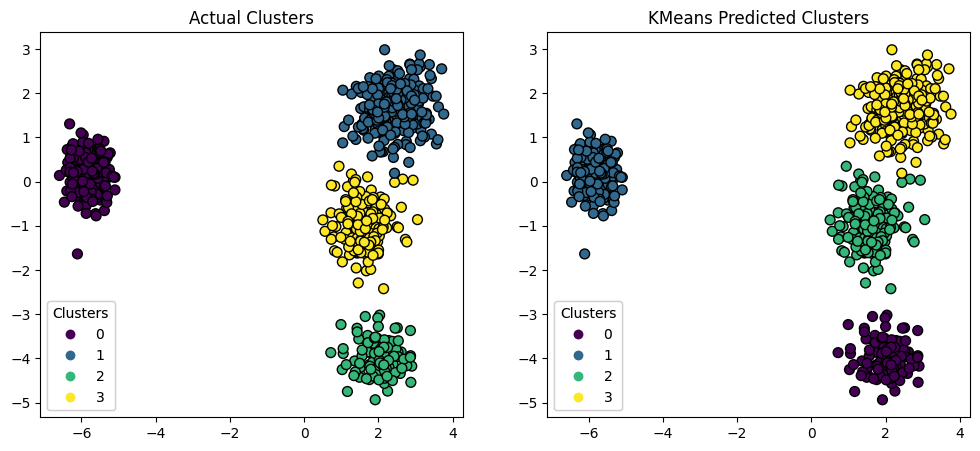

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

plot_2d(coords, y, title="Actual Clusters", ax=ax1)
plot_2d(coords, kmeans.labels_, title="KMeans Predicted Clusters", ax=ax2)

plt.show()

We can see that **k-means was able to find the four distinct clusters**, which closely match the actual clusters generated by the make_blobs function.

**Note that the specific colors (labels) used are not important, what matters is that the algorithm is able to separate the different clusters from each other.**

--

Sometimes, looking at the data in 2D may not be enough to fully understand the underlying structure and patterns.

If that's the case, we can use more PCA components, and **plot the data in 3D**.

In [7]:
plot_3d(coords, labels=kmeans.labels_, title="KMeans clustering")

### K-medoids

K-medoids is a clustering algorithm **similar to KMeans, with some key differences**.

Like k-means, k-medoids is aims to split the dataset into a predefined `k` number of clusters. However, K-medoids uses *medoids* (i.e., the most centrally located data point in each cluster) instead of *centroids* as the representative point for each cluster.

- This makes K-medoids **more robust to noise and outliers**, and allows it to handle non-spherical and non-convex clusters.
- The central point of the cluster with KMedoids has to be **a point from the dataset**, while k-means uses any point in the space.

This difference is illustrated here:


<div align="left">
<img src="https://github.com/schwallergroup/ai4chem_course/blob/main/notebooks/04%20-%20Unsupervised%20Learning/img/K-MeansAndK-Medoids.png?raw=1" width="600"/>
</div>

K-means typically uses the Euclidean distance metric, while K-medoids work with **any distance metric**, making it more versatile and adaptable to different types of datasets.

#### Try different distance metrics here, and see how the clustering changes!

Available options include

- euclidean
- jaccard
- cityblock
- cosine
- l2
- minkowski


> You can read more about distance metrics ![here](https://medium.com/geekculture/7-important-distance-metrics-every-data-scientist-should-know-11e1b0b2ebe3) and find all the available options ![here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html).

In [8]:
d_metric = 'euclidean'  # Change me!

kmedoids = KMedoids(
    n_clusters=n_clusters,
	random_state=42,
	init='k-medoids++',
	metric=d_metric,
	max_iter=50000
)
kmedoids.fit(X_binary)


KMedoids(init='k-medoids++', max_iter=50000, n_clusters=4, random_state=42)

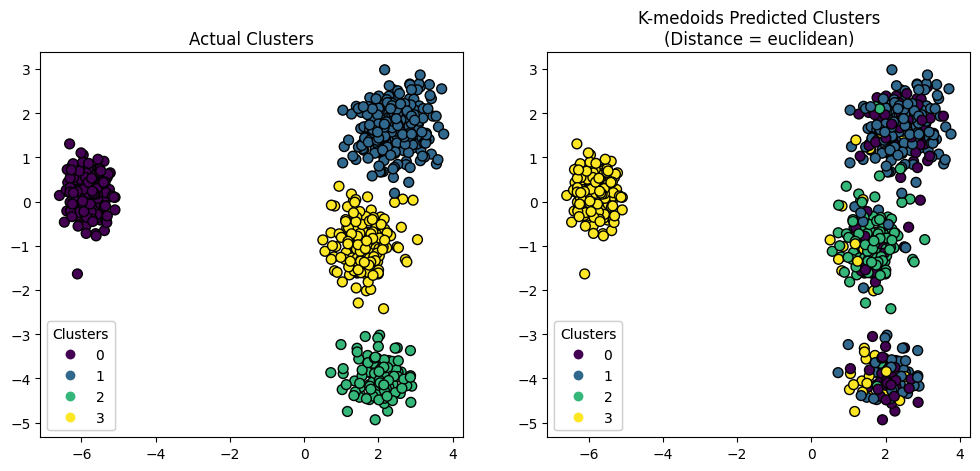

In [9]:
# And here are the results from
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

plot_2d(coords, y, title="Actual Clusters", ax=ax1)
plot_2d(coords, kmedoids.labels_, title=f"K-medoids Predicted Clusters\n(Distance = {d_metric})", ax=ax2)

plt.show()

In [10]:
plot_3d(coords, labels=kmedoids.labels_, title=f"KMedoids clustering\n(Distance = {d_metric})")

### DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

DBSCAN is a clustering algorithm that groups data points based on their density.

It can find **arbitrarily shaped clusters** and is **robust to noise**. Unlike K-means and K-medoids, DBSCAN **does not require specifying the number of clusters beforehand**.

 The key idea behind DBSCAN is that a cluster is a dense region of points separated from other dense regions by areas of lower point density.

DBSCAN requires two parameters:

- eps (epsilon): The maximum distance between two points to be considered as neighbors.
- min_samples: The minimum number of points required to form a dense region (core points).

The algorithm works by defining a neighborhood around each data point and grouping together points that are close to each other based on the eps parameter. If a neighborhood contains at least min_samples points, the point is considered as a core point. Points that are not core points but are reachable from a core point belong to the same cluster as the core point. Points that are not reachable from any core point are treated as noise.



In [11]:
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='jaccard')
dbscan.fit(X_binary)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2361: DataConversionWarning:

Data was converted to boolean for metric jaccard



DBSCAN(metric='jaccard')

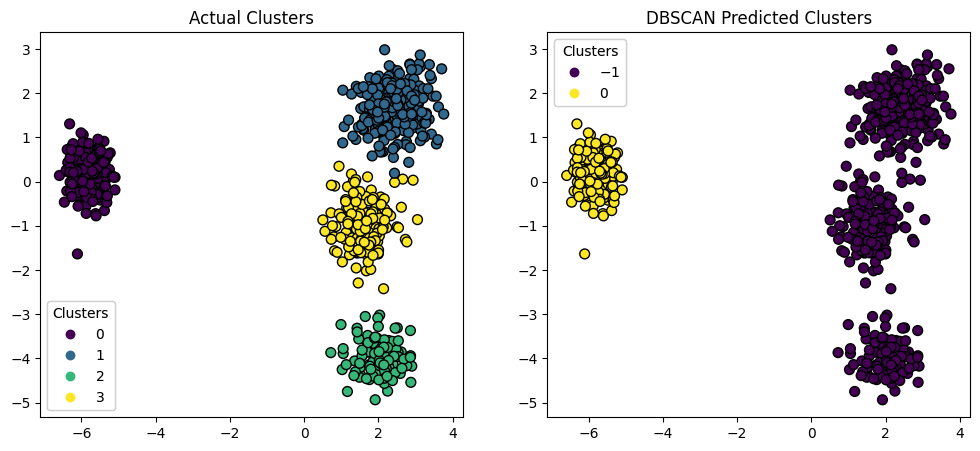

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

plot_2d(coords, y, title="Actual Clusters", ax=ax1)
plot_2d(coords, dbscan.labels_, title="DBSCAN Predicted Clusters", ax=ax2)

plt.show()

### Butina Clustering Algorithm

The Butina clustering algorithm is designed for handling **large datasets with binary features**. It is particularly **useful in chemoinformatics for clustering molecular fingerprints**, which are binary representations of molecular structures.

Butina clustering algorithm is a single-linkage hierarchical clustering method that merges clusters based on a user-defined similarity threshold (cutoff). See more ![in the paper](https://pubs.acs.org/doi/full/10.1021/ci9803381).

> One of its main advantages over other clustering methods is the ability to work well with binary data and non-Euclidean distance metrics, like Jaccard.

To set the cutoff parameter for Butina clustering, follow these steps:

1. Calculate the pairwise distances (using Jaccard or another suitable metric) for your dataset.

2. Visualize the distribution of distances by plotting a histogram.

3. Analyze the histogram and choose a cutoff value that corresponds to a reasonable threshold for distinguishing between similar and dissimilar data points.

Once you have chosen an appropriate cutoff value, use it as the input parameter for the Butina clustering algorithm.

#### You can experiment with different cutoff values to find the one that produces the most satisfactory clustering results for your data.


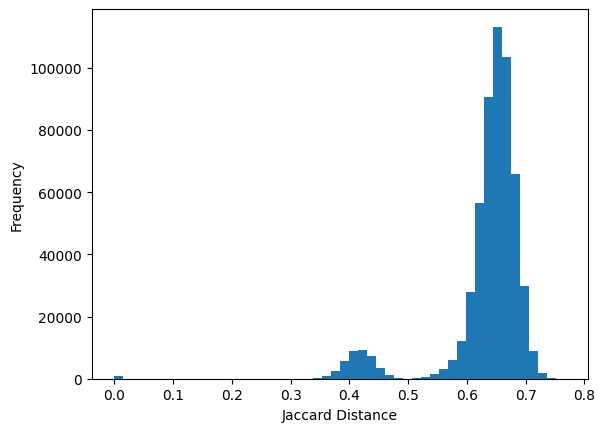

In [13]:
distances = pairwise_distances(X_binary.astype(bool), metric='jaccard')

plt.hist(distances.flatten(), bins=50)
plt.xlabel("Jaccard Distance")
plt.ylabel("Frequency")
plt.show()


In [14]:
class ButinaClustering:
    def __init__(self, cutoff=0.8, metric='jaccard'):
        self.cutoff = cutoff
        self.metric = metric

    def fit(self, x):
        """
        Perform Butina clustering on a set of fingerprints.

        :param x: A numpy array of binary data
        :return: self
        """
        # Calculate the distance matrix
        distance_matrix = []
        x = x.astype(bool)
        for i in range(1, len(x)):
            distances = pairwise_distances(x[i,:].reshape(1, -1), x[:i,:], metric=self.metric)
            distance_matrix.extend(distances.flatten().tolist())

        # Perform Butina clustering
        clusters = Butina.ClusterData(distance_matrix, len(x), self.cutoff, isDistData=True)
        self.clusters = clusters

        # Assign cluster labels to each data point
        cluster_labels = np.full(len(x), -1, dtype=int)
        for label, cluster in enumerate(clusters):
            for index in cluster:
                cluster_labels[index] = label

        self.labels_ = cluster_labels


    def fit_predict(self, x):
      self.fit(x)
      return self.labels_

In [15]:
cutoff = 0.65  # Change me!

butina = ButinaClustering(cutoff=cutoff, metric='jaccard')
butina.fit(X_binary)

print(f"{len(butina.clusters)} clusters were found with a cutoff = {cutoff}")

8 clusters were found with a cutoff = 0.65


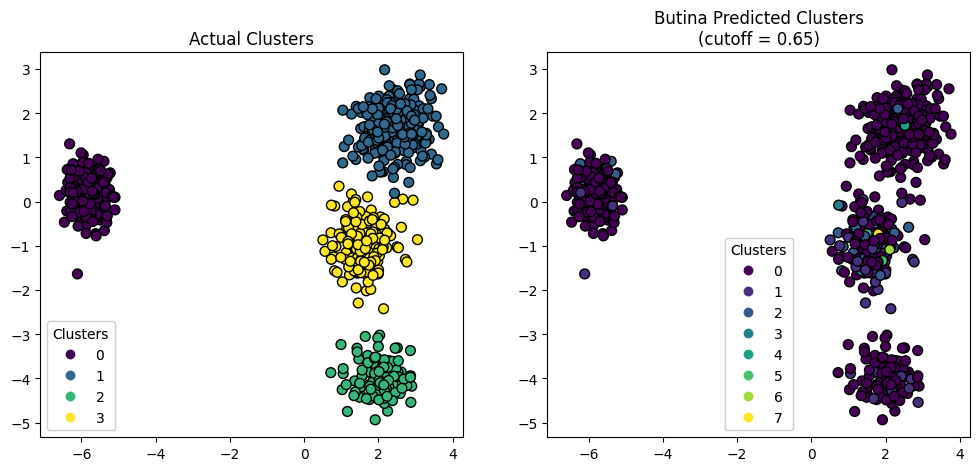

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

plot_2d(coords, y, title="Actual Clusters", ax=ax1)
plot_2d(coords, butina.labels_, title=f"Butina Predicted Clusters\n(cutoff = {cutoff})", ax=ax2)

plt.show()

## Evaluation

As should be clear from the above exercises, all the algorithms give **different results**, and the results also **depend on the parameters chosen**. The questino is then,

> How do I know if the results from the algorithm are good?


In the next section, we will evaluate how clustering metrics like **inertia** and **silhouette** score can help us uncover the optimal number of clusters when using K-means or K-medoids algorithm.


### Inertia
Inertia is the sum of squared distances between each data point and its assigned cluster centroid.

> Inertia is a measure of how tightly grouped the data points are within each cluster.

A **lower inertia value** indicates that the data points within a cluster are closer to their centroid, which is **desirable**.

But beware, inertia can be **sensitive to the number of clusters**, as increasing the number of clusters will generally reduce the inertia.
**Therefore, selecting the optimal number of clusters based on inertia alone can lead to overfitting**.


### Silhouette Score

> The silhouette score is a measure of how similar a data point is to its own cluster compared to other clusters.

The silhouette score ranges from -1 to 1. A **high silhouette score** indicates that **data points are well-matched to their own cluster** and poorly matched to neighboring clusters. A negative silhouette score implies that data points might have been assigned to the wrong cluster.

The silhouette score can be **more robust than inertia** in determining the optimal number of clusters, as it considers both cohesion (how closely related the data points within a cluster are) and separation (how distinct the clusters are from each other).

---

To compare inertia and silhouette scores and determine the optimal number of clusters for the data, you can follow these steps:

1. Loop through a range of cluster numbers (e.g., 2 to 10) and fit the clustering algorithms (KMeans, KMedoids, etc.) for each number of clusters.
2. Calculate and store the inertia and silhouette scores for each clustering model and each number of clusters.
3. Plot the inertia and silhouette scores as a function of the number of clusters.
4. Examine the plots to determine the optimal number of clusters.

> For the inertia plot, look for an "elbow" point, where the rate of decrease in inertia starts to level off.
> For the silhouette plot, look for the highest silhouette score.


In [17]:
n_clusters = 4
algorithms = {
    'KMeans': KMeans(n_clusters=n_clusters, n_init=10, init='k-means++', random_state=42),
    'KMedoids': KMedoids(n_clusters=n_clusters, init='k-medoids++', metric='jaccard', random_state=42)
}

In [18]:
def plot_inertia_and_silhouette(data, algorithms, min_clusters, max_clusters):

    for name, algorithm in algorithms.items():
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        fig.suptitle(f'{name}')

        inertia = []
        silhouette_scores = []
        for n_clusters in range(min_clusters, max_clusters + 1):
            algorithm.set_params(n_clusters=n_clusters)
            labels = algorithm.fit_predict(data)
            inertia.append(algorithm.inertia_)
            silhouette_scores.append(silhouette_score(data, labels))

        ax1.plot(range(min_clusters, max_clusters + 1), inertia, label=name)
        ax2.plot(range(min_clusters, max_clusters + 1), silhouette_scores, label=name)

    ax1.set_xlabel("Number of clusters")
    ax1.set_ylabel("Inertia")
    ax1.legend()

    ax2.set_xlabel("Number of clusters")
    ax2.set_ylabel("Silhouette Score")
    ax2.legend()

    plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2361: DataConversionWarning:

Data was converted to boolean for metric jaccard

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2361: DataConversionWarning:

Data was converted to boolean for metric jaccard

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2361: DataConversionWarning:

Data was converted to boolean for metric jaccard

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2361: DataConversionWarning:

Data was converted to boolean for metric jaccard

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2361: DataConversionWarning:

Data was converted to boolean for metric jaccard

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2361: DataConversionWarning:

Data was converted to boolean for metric jaccard

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2361: DataConversionWarning:

Data was conve

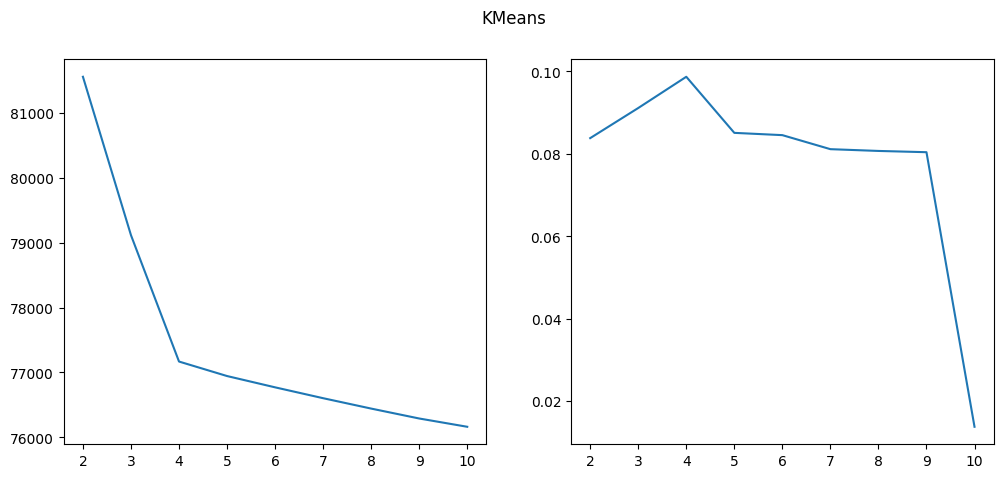

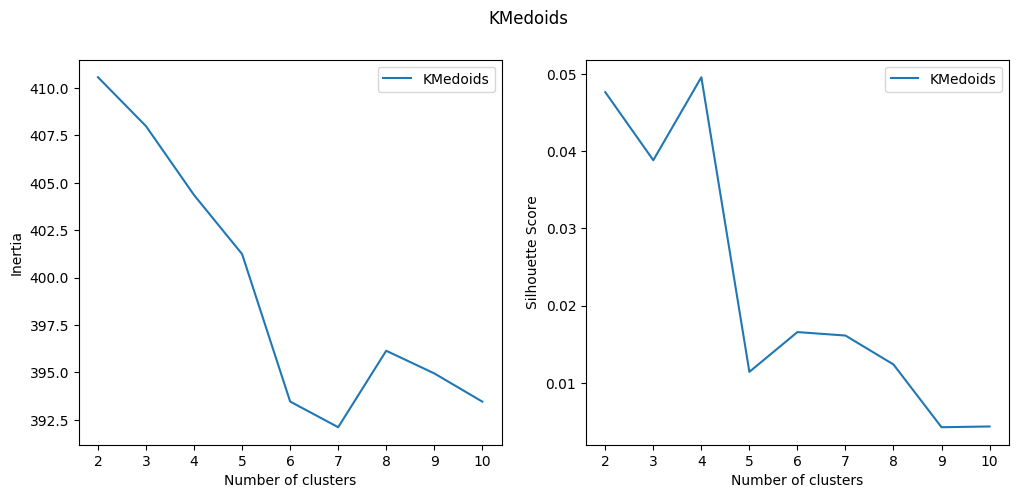

In [19]:
min_clusters = 2
max_clusters = 10

plot_inertia_and_silhouette(X_binary.astype(bool), algorithms, min_clusters, max_clusters)

---

# Exercise

Now it's your turn to find the optimal number of clusters in a chemical dataset using K-means or K-medoids algorithms and the inertia vs. silhouette metrics.

Using the `plot_inertia_and_silhouette` function estimate the correct number of clusters in the `unknown_clusters` dataset.

- Read the dataset in data/unknown_clusters.csv. NOTE: Use the variable `data_ex`
- Featurize SMILES using Morgan fingerprints. NOTE: Use the variable `X_ex` to store the featurized SMILES.
- Run the `plot_inertia_and_silhouette` function to estimate the optimal number of clusters

In [ ]:
# YOUR CODE
data_ex =
# ...
X_ex =
# ...

Once you've estimated the number of clusters, update the N_CLUSTERS variable with the correct number and run a visualization function to see some of the molecules in your clusters.

In [ ]:
# YOUR CODE
N_CLUSTERS =

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from rdkit import Chem
from rdkit.Chem import Draw

# Perform clustering using KMeans and KMedoids
kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=10, random_state=42).fit(X_ex)
kmedoids = KMedoids(n_clusters=N_CLUSTERS, init='k-medoids++', metric='jaccard', random_state=42).fit(X_ex.astype(bool))


# Function to select a few representative molecules from each cluster
def plot_representative_molecules(labels, smiles, n_clusters, n_molecules=5):
    for i in range(n_clusters):
        cluster_indices = np.where(labels == i)[0]
        molecules = [Chem.MolFromSmiles(smile) for smile in smiles]
        cluster_molecules = [molecules[idx] for idx in cluster_indices]

        # Select the first n_molecules from the cluster
        selected_molecules = cluster_molecules[:n_molecules]

        # Plot the selected molecules
        img = Draw.MolsToGridImage(selected_molecules, molsPerRow=n_molecules, subImgSize=(200, 200))
        print(f"Cluster {i+1}:")
        display(img)

# Plot the representative molecules for KMeans
print("KMeans Clusters:")
plot_representative_molecules(kmeans.labels_, data_ex['smiles'], N_CLUSTERS)

# Plot the representative molecules for KMedoids
print("KMedoids Clusters:")
plot_representative_molecules(kmedoids.labels_, data_ex['smiles'], N_CLUSTERS)
